In [1]:
!pip3 install statsmodels

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg

In [3]:
train = pd.read_csv("train.csv")
train

,datetime,total
0,01.01.2005 00:00:00,?
1,01.01.2005 01:00:00,154140
2,01.01.2005 02:00:00,157818
3,01.01.2005 03:00:00,149311
4,01.01.2005 04:00:00,138282
...,...,...
35059,31.12.2008 19:00:00,249376
35060,31.12.2008 20:00:00,246511
35061,31.12.2008 21:00:00,226469
35062,31.12.2008 22:00:00,199907


In [4]:
train.replace("?", 0, inplace=True)
train

,datetime,total
0,01.01.2005 00:00:00,0
1,01.01.2005 01:00:00,154140
2,01.01.2005 02:00:00,157818
3,01.01.2005 03:00:00,149311
4,01.01.2005 04:00:00,138282
...,...,...
35059,31.12.2008 19:00:00,249376
35060,31.12.2008 20:00:00,246511
35061,31.12.2008 21:00:00,226469
35062,31.12.2008 22:00:00,199907


In [19]:
series = train.total.values

In [30]:
import matplotlib.pyplot as plt

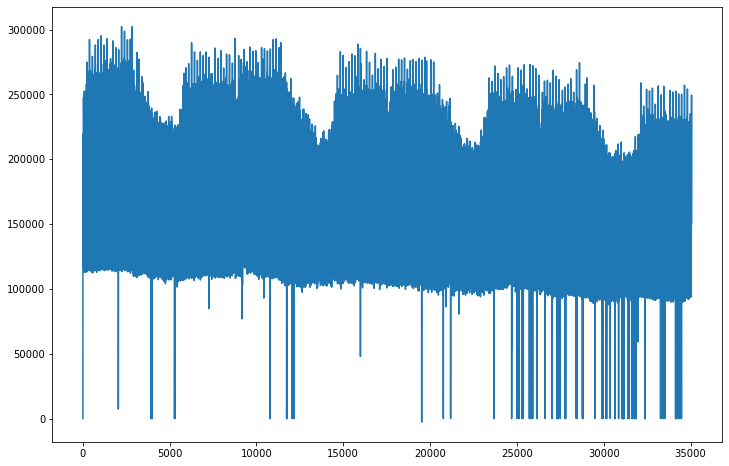

In [42]:
fig = plt.figure(figsize=(12, 8))

plt.plot(train["total"])

In [6]:
ar = AutoReg(series, lags=168).fit()

C:\Users\gleb\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [7]:
answer = ar.predict(start=35064, end=35064+4344-1, dynamic=False)

In [8]:
with open("answer.txt", "w") as f:
    for v in answer:
        f.write(str(v))
        f.write('\n')